# 1.2 Model design

Using the heatmap, we can understand the correlations in our dataset. Values closer to one indicate a strong positive correlation, while values closer to -1 suggest a strong negative correlation.

For example, gender and height show a moderate to strong positive correlation (0.5), suggesting that taller individuals are more likely to be male and taller individuals tend to weigh more, which explains the positive correlation (0.29) between weight and height.

Another noteworthy correlation is between age and cardiovascular disease (cardio), which has a moderate correlation (0.23). This relationship will be further analyzed later on.

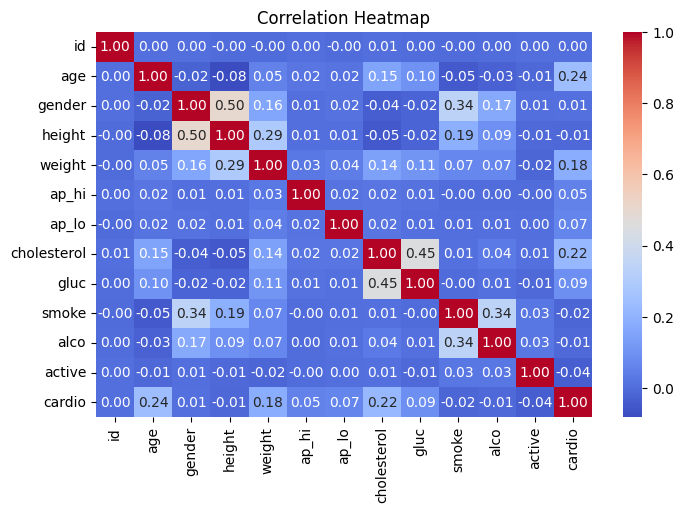

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


filepath = '../Lab/data/cardio_train.csv'
df = pd.read_csv(filepath, delimiter=";")
df = df.dropna()

corr_matrix = df.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 1.2.1 Feature Engineering

$$BMI = \frac{weight (kg)}{height (m)^2}$$

This code put individuals into different weight categories based on their Body Mass Index (BMI) using the World Health Organization (WHO) classification. Here's a breakdown of the categories:

- (1)Underweight: BMI < 18.5
- (2)Normal weight: 18.5 ≤ BMI < 25
- (3)Overweight: 25 ≤ BMI < 30
- (4)Obese (Class I): 30 ≤ BMI < 35
- (5)Obese (Class II): 35 ≤ BMI < 40
- (6)Obese (Class III): BMI ≥ 40

By applying these thresholds, the code categorizes individuals' BMI into one of these six categories for further analysis.

**Source:** https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations

In [13]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2 # BMI formula

lower_bound = 15
upper_bound = 40

df = df[(df['BMI'] >= lower_bound) & (df['BMI'] <= upper_bound)] # BMI should be in range of lower and upper

bins = [0, 18.5, 25, 30, 35, 40, np.inf] 

labels = [1, 2, 3, 4, 5, 6]
df['BMI Category'] = pd.cut(df['BMI'], bins=bins, labels=labels)


This code below is used to categorize blood pressure into different categories based on the indivudals values of systolic (ap_hi) and diastolic (ap_lo) blood pressure.

- 1.Normal Blood Pressure: Systolic < 120 and Diastolic < 80
- 2.Elevated Blood Pressure: Systolic between 120 and 129 and Diastolic < 80
- 3.Hypertension Stage 1: Systolic between 130 and 139 or Diastolic between 80 and 89
- 4.Hypertension Stage 2: Systolic between 140 and 180 or Diastolic between 90 and 120
- 5.Hypertensive Crisis: Systolic > 180 or Diastolic > 120


**Source:** https://www.ama-assn.org/delivering-care/hypertension/what-high-blood-pressure#:~:text=Normal%3A%20%3C%20120%20mm%20Hg%20systolic,%E2%89%A5%2090%20mm%20Hg%20DBP


In [14]:
systolic_low = 90
systolic_high = 180
diastolic_low = 60
diastolic_high = 120


df = df[(df['ap_hi'] >= systolic_low) & (df['ap_hi'] <= systolic_high) &
        (df['ap_lo'] >= diastolic_low) & (df['ap_lo'] <= diastolic_high)]

bins_combined = [0, 120, 130, 140, systolic_high, systolic_high + diastolic_high + 1]
labels_combined = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']

df['BP Category'] = pd.cut(df['ap_hi'] + df['ap_lo'], bins=bins_combined, labels=labels_combined)

## 1.2.2 Make two dataset

In [15]:

df_copy1 = df.copy()
df_copy2 = df.copy()


df_copy1.drop(['ap_hi', 'ap_lo','height','weight','BMI'], axis=1, inplace=True) #remove columns 
df_copy1 = pd.get_dummies(df_copy1, columns=['BMI Category', 'BP Category', 'gender'], drop_first=True)


df_copy2.drop(['BMI Category','BP Category','height','weight'], axis=1, inplace=True)
df_copy2 = pd.get_dummies(df_copy2, columns=['gender'], drop_first=True) #one-hot encoding


### Correlation heatmap copy_1
Reviewing the cardio column, It shows the strongest positive correlation is cardio and age (0.24). While this correlation may not be notably strong, it stands out as the most significant relationship identified among the variables studied in relation to cardiovascular disease and will be used for training.

I also notice that the categories BMI obese class III, Blood pressure elevated, and Blood pressure hypertension stage 1 are blank. This indicates that there is no data for individuals falling into these categories.

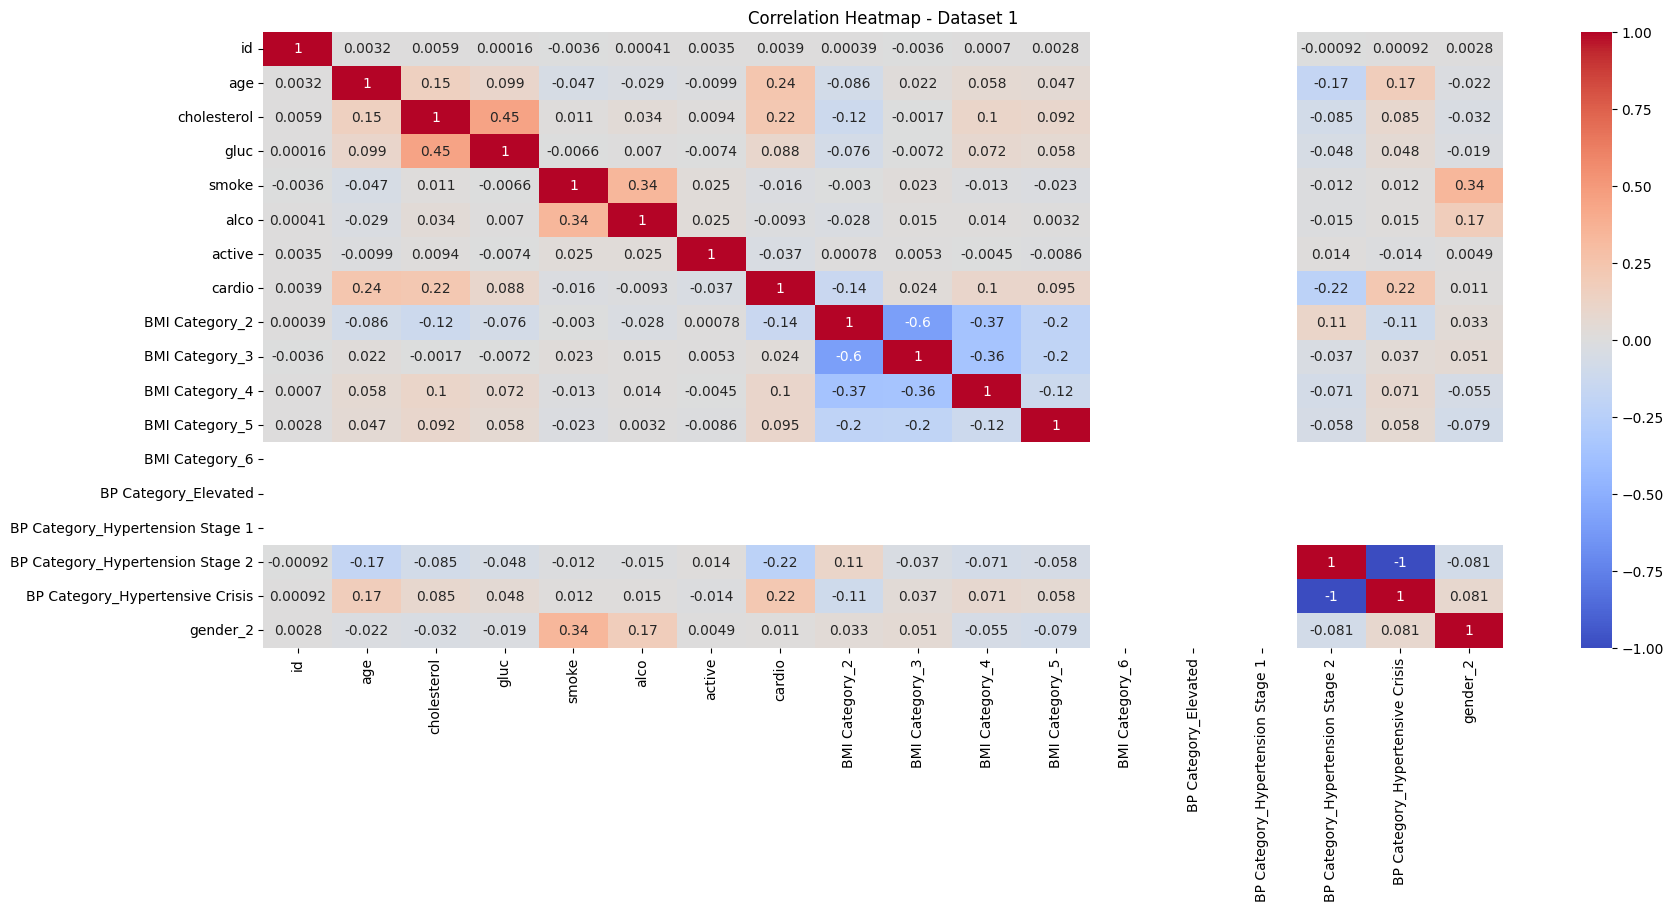

In [18]:
matrix_1 = df_copy1.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(matrix_1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Dataset 1')
plt.show()

### Correlation Heatmap Copy_2
In the second copy of the original dataset, the cardiovascular disease column shows stronger correlations with variables such as ap_lo, ap_hi, age and BMI

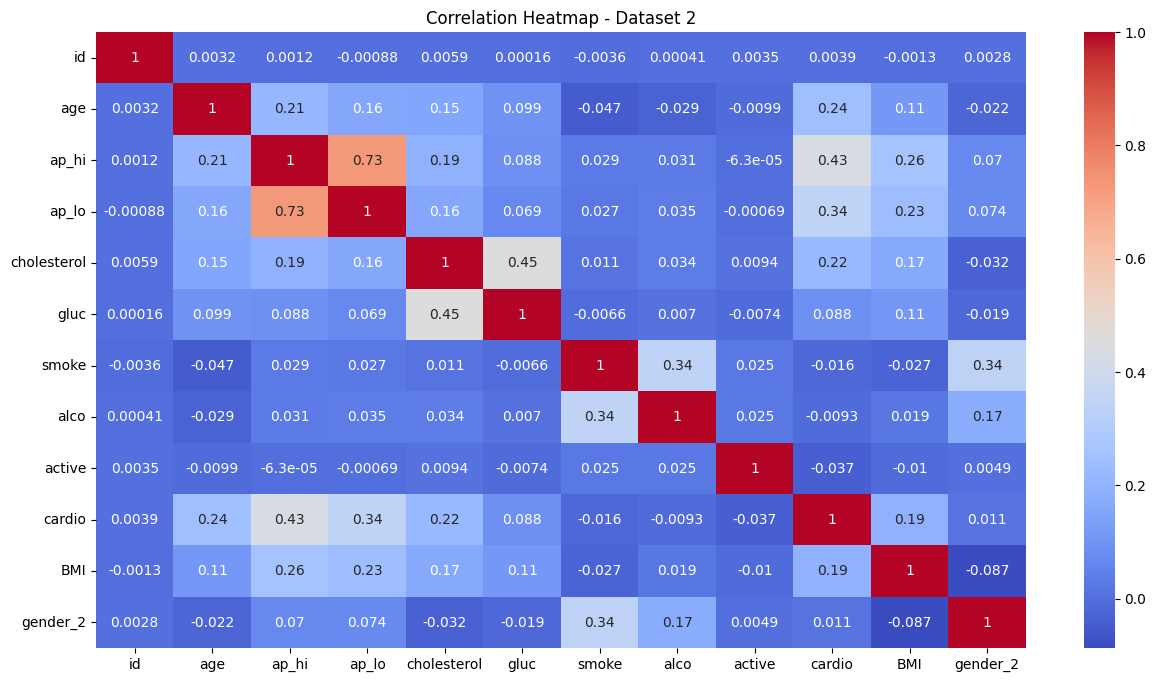

In [19]:
matrix_2 = df_copy2.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(matrix_2, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Dataset 2')
plt.show()

## 1.2.3 Performance


second dataset was selected due to its fewer features, which helps reduce the risk of overfitting.The columns in the second datset also shows stronger correlations with the target variable compared to first dataset. 

SVM was chosen for its accuracy, which, while not the highest, was still better than the accuracy of KNN and Random Forest.

In [20]:
def prepare_data(df, columns):
    X = df[columns]
    y = df['cardio']
    return X, y

def print_best_results(grid_search, dataset_num):
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for Dataset {dataset_num}: {best_params}")
    print(f"Best Score for Dataset {dataset_num}: {best_score}")

X1, y1 = prepare_data(df_copy1, ['age'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2, y2 = prepare_data(df_copy2, ['age', 'ap_hi', 'ap_lo', 'BMI'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5],
    'rf__min_samples_split': [2, 5]
}

grid_search_1 = GridSearchCV(pipeline, param_grid, cv=5)
grid_search_1.fit(X1_train, y1_train)
print_best_results(grid_search_1, 1)

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=5)
grid_search_2.fit(X2_train, y2_train)
print_best_results(grid_search_2, 2)

Best Parameters for Dataset 1: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best Score for Dataset 1: 0.6004290252088109
Best Parameters for Dataset 2: {'rf__max_depth': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Score for Dataset 2: 0.7216555297366684


In [26]:
def prepare_data(df, columns):
    X = df[columns]
    y = df['cardio']
    return X, y

def print_best_results(grid_search, dataset_num):
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for Dataset {dataset_num}: {best_params}")
    print(f"Best Score for Dataset {dataset_num}: {best_score}")

X1, y1 = prepare_data(df_copy1, ['age'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2, y2 = prepare_data(df_copy2, ['age', 'ap_hi', 'ap_lo', 'BMI'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search_1 = GridSearchCV(pipeline_knn, param_grid, cv=5)
grid_search_1.fit(X1_train, y1_train)
print_best_results(grid_search_1, 1)

grid_search_2 = GridSearchCV(pipeline_knn, param_grid, cv=5)
grid_search_2.fit(X2_train, y2_train)
print_best_results(grid_search_2, 2)

Best Parameters for Dataset 1: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best Score for Dataset 1: 0.5533010807713064
Best Parameters for Dataset 2: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best Score for Dataset 2: 0.6811901422446343


In [32]:
def prepare_data(df, columns):
    X = df[columns]
    y = df['cardio']
    return X, y

def print_best_results(grid_search, dataset_num):
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for Dataset {dataset_num}: {best_params}")
    print(f"Best Score for Dataset {dataset_num}: {best_score}")

X1, y1 = prepare_data(df_copy1, ['age'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2, y2 = prepare_data(df_copy2, ['age', 'ap_hi', 'ap_lo', 'BMI'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__C': [0.1, 1],
    'svm__kernel': ['rbf']
}

grid_search_1 = GridSearchCV(pipeline_svm, param_grid, cv=5)
grid_search_1.fit(X1_train, y1_train)
print_best_results(grid_search_1, 1)

grid_search_2 = GridSearchCV(pipeline_svm, param_grid, cv=5)
grid_search_2.fit(X2_train, y2_train)
print_best_results(grid_search_2, 2)

Best Parameters for Dataset 1: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best Score for Dataset 1: 0.601332448337002
Best Parameters for Dataset 2: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best Score for Dataset 2: 0.722201304041244


## 1.3 Packaging and Demo

### 1.3.1 Save model

In [33]:
import joblib

best_df = df_copy2

test_samples = best_df.sample(n=100)
test_samples.to_csv('test_samples.csv', index=False)
training_data = best_df.drop(test_samples.index)

X_train = training_data.drop(columns=['cardio'])
y_train = training_data['cardio']

best_svm_model = SVC(C=0.1, kernel='rbf', probability=True)
best_svm_model.fit(X_train, y_train)

joblib.dump(best_svm_model, 'SVM1_model.pkl', compress=True)

### 1.3.2 Load model

In [11]:
test_samples = pd.read_csv('test_samples.csv')
loaded_model = joblib.load('svm_model.pkl')

X_test = test_samples.drop(columns=['cardio'])

predictions = loaded_model.predict(X_test)
probabilities = loaded_model.predict_proba(X_test)

prediction_df = pd.DataFrame({
    'probability class 0': probabilities[:, 0],
    'probability class 1': probabilities[:, 1],
    'prediction': predictions
})

prediction_df.to_csv('prediction.csv', index=False)


## Result

The SVM model used in this report predicts 47% of individuals as negative and 53% as positive for cardiovascular disease. Comparing this to the original dataset, where 49.97% are negative and 50.03% are positive, suggests that the model may not have been properly tuned. Run time was also a factor.


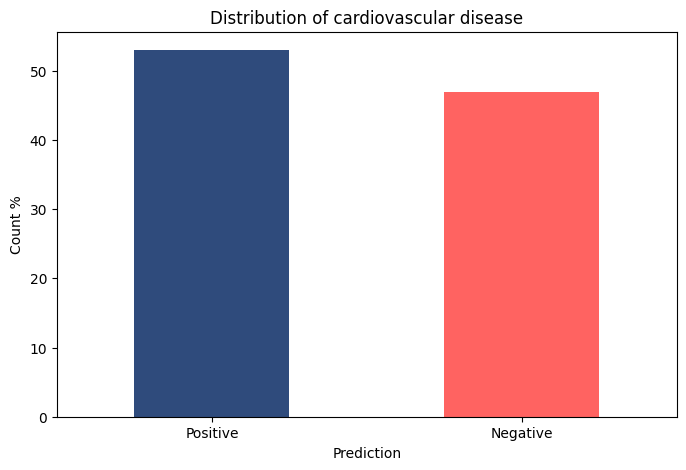

Positive test:53.0%
Neagative test:47.0%


In [52]:
df_prediction = pd.read_csv('../Lab/data/prediction.csv')

df_prediction['prediction'].replace({0: 'Negative', 1: 'Positive'}, inplace=True)
plt.figure(figsize=(8, 5))
df_prediction['prediction'].value_counts().plot(kind='bar', color = ['#2f4b7c','#ff6361'])
plt.title('Distribution of cardiovascular disease')
plt.xlabel('Prediction')
plt.ylabel('Count %')
plt.xticks(rotation=0)
plt.show()


percentage_0 = (df_prediction['prediction'] == 'Negative').mean() * 100
percentage_1 = (df_prediction['prediction'] == 'Positive').mean() * 100
print(f'Positive test:{percentage_1}%')
print(f'Neagative test:{percentage_0}%')

